In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("C:\\Users\\Bala Vignesh.A\\Desktop\\SCMA 632\\assam data.csv", low_memory=False)

# Filter data for Assam

In [4]:
assam_data = data[data['state_1'] == 'ASSM']

# Check for missing values

In [5]:
missing_values = assam_data.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
slno              0
grp               0
Round_Centre      0
FSU_number        0
Round             0
                 ..
foodtotal_q       0
state_1           0
Region            0
fruits_df_tt_v    0
fv_tot            0
Length: 384, dtype: int64


# Replace missing values with mean

In [17]:
assam_data = assam_data.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

# Verify that there are no more missing values

In [18]:
missing_values_after = assam_data.isna().sum()
print("Missing values after replacement for Assam:")
print(missing_values_after)


Missing values after replacement for Assam:
slno              0
grp               0
Round_Centre      0
FSU_number        0
Round             0
                 ..
foodtotal_q       0
state_1           0
Region            0
fruits_df_tt_v    0
fv_tot            0
Length: 384, dtype: int64


# Identify and remove outliers using the IQR method

In [19]:
numeric_columns = assam_data.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    Q1 = assam_data[col].quantile(0.25)
    Q3 = assam_data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((assam_data[col] < (Q1 - 1.5 * IQR)) | (assam_data[col] > (Q3 + 1.5 * IQR)))
    print(f"{col} has {outliers.sum()} outliers in Assam")
    assam_data = assam_data[~outliers]

slno has 832 outliers in Assam
Round_Centre has 0 outliers in Assam
FSU_number has 0 outliers in Assam
Round has 0 outliers in Assam
Schedule_Number has 0 outliers in Assam
Sample has 0 outliers in Assam
Sector has 0 outliers in Assam
state has 0 outliers in Assam
State_Region has 0 outliers in Assam
District has 0 outliers in Assam
Stratum_Number has 0 outliers in Assam
Sub_Stratum has 0 outliers in Assam
Schedule_type has 0 outliers in Assam
Sub_Round has 0 outliers in Assam
Sub_Sample has 0 outliers in Assam
FOD_Sub_Region has 40 outliers in Assam
Hamlet_Group_Sub_Block has 0 outliers in Assam
t has 12 outliers in Assam
X_Stage_Stratum has 0 outliers in Assam
HHS_No has 155 outliers in Assam
Level has 0 outliers in Assam
Filler has 0 outliers in Assam
hhdsz has 58 outliers in Assam
NIC_2008 has 0 outliers in Assam
NCO_2004 has 146 outliers in Assam
HH_type has 103 outliers in Assam
Religion has 18 outliers in Assam
Social_Group has 0 outliers in Assam
Whether_owns_any_land has 104 o

# Check if the column exists and rename it

In [20]:
if 'old_district_column_name' in assam_data.columns:
    assam_data.rename(columns={'old_district_column_name': 'new_district_column_name'}, inplace=True)
else:
    print("Column 'old_district_column_name' doesn't exist in the data.")

Column 'old_district_column_name' doesn't exist in the data.


# Summarize the critical variables region-wise

In [21]:
region_summary = assam_data.groupby('FOD_Sub_Region').agg(
    avg_No_of_Meals_per_day=('No_of_Meals_per_day', 'mean'),
    min_No_of_Meals_per_day=('No_of_Meals_per_day', 'min'),
    max_No_of_Meals_per_day=('No_of_Meals_per_day', 'max')
).reset_index()


# Summarize the critical variables district-wise

In [22]:
district_summary = assam_data.groupby('District').agg(
    avg_No_of_Meals_per_day=('No_of_Meals_per_day', 'mean'),
    min_No_of_Meals_per_day=('No_of_Meals_per_day', 'min'),
    max_No_of_Meals_per_day=('No_of_Meals_per_day', 'max')
).reset_index()

# Mutate the District column

In [23]:
assam_data['District'] = assam_data['District'].apply(lambda x: 'ASSM Urban' if x == '18' else x)


# Identify the top and bottom three districts of consumption

In [24]:
top_three_districts = district_summary.sort_values(by='avg_No_of_Meals_per_day', ascending=False).head(3)
bottom_three_districts = district_summary.sort_values(by='avg_No_of_Meals_per_day').head(3)


# Inspect unique values in No_of_Meals_per_day for each District

In [42]:
unique_values_per_district = assam_data.groupby('District')['No_of_Meals_per_day'].unique()
print("Unique values of No_of_Meals_per_day for each District:")
for district, unique_values in unique_values_per_district.items():
    print(f"{district}: {unique_values}")

Unique values of No_of_Meals_per_day for each District:
19: [3.]
23: [3.]



# ANOVA analysis

In [35]:
import statsmodels.api as sm

In [39]:
from statsmodels.formula.api import ols

In [47]:
district_groups = [assam_data[assam_data['District'] == district]['No_of_Meals_per_day'].dropna() for district in assam_data['District'].unique()]
anova_result = f_oneway(*district_groups)

# Display ANOVA results

In [57]:
model = ols('No_of_Meals_per_day ~ (District)', data=assam_data).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

In [58]:
print("ANOVA results:\n")
print(anova_result)

ANOVA results:

                sum_sq   df         F    PR(>F)
District  1.314768e-31  1.0  0.002545  0.967914
Residual  5.167039e-29  1.0       NaN       NaN


In [59]:
anova_summary = anova_result.reset_index()
anova_summary.columns = ['Source', 'sum_sq', 'df', 'F', 'PR(>F)']

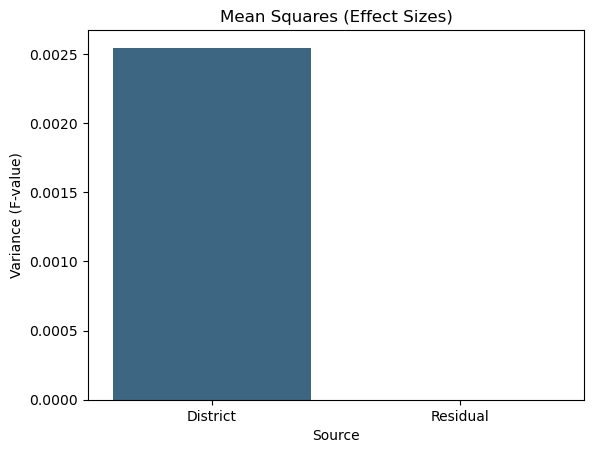

In [60]:
sns.barplot(x='Source', y='F', data=anova_summary, palette='viridis')
plt.title('Mean Squares (Effect Sizes)')
plt.xlabel('Source')
plt.ylabel('Variance (F-value)')
plt.show()

##In conclusion, the ANOVA results suggest that the District variable does not have a significant effect on the mean of No_of_Meals_per_day.